In [1]:
import scipy.io as scio
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
import pickle
import cv2
from tensorflow.python.client import device_lib
import math
import pandas as pd
device_lib.list_local_devices()
import shutil
import pathlib
import random
import sys
import colorsys
import copy
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.backend as K
import gc
import sklearn
np.random.seed(2023)
random.seed(2023)

In [8]:
Real_ALL_Time = np.concatenate((Time_series_R,Time_June,Time_New),axis=0)
Real_ALL_Force = np.concatenate((Force_R,Force_June,Force_New ),axis=0)
Real_ALL_Location =  np.concatenate((Location_R,Location_June,Location_New),axis=0)
Temp_list_Real = np.arange(0,len(Real_ALL_Time))
np.random.shuffle(Temp_list_Real)
Real_ALL_Time = Real_ALL_Time[Temp_list_Real]
Real_ALL_Location =Real_ALL_Location[Temp_list_Real]
Real_ALL_Force = Real_ALL_Force[Temp_list_Real]

Train_Real_ALL_Time,Test_Real_ALL_Time = Real_ALL_Time[:int(0.8*len(Real_ALL_Time))], Real_ALL_Time[int(0.8*len(Real_ALL_Time)):]
Train_Real_ALL_Force, Test_Real_ALL_Force = Real_ALL_Force[:int(0.8*len(Real_ALL_Time))],Real_ALL_Force[int(0.8*len(Real_ALL_Time)):]
Train_Real_ALL_Location,Test_Real_ALL_Location = Real_ALL_Location[:int(0.8*len(Real_ALL_Time))],Real_ALL_Location[int(0.8*len(Real_ALL_Time)):]

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
from tensorflow import keras, data
from tensorflow.keras import layers, regularizers, activations
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import scipy
from scipy.fft import fft,ifft
import math

class Encoder(keras.Model):
    def __init__(self, time_step, x_dim, z_dim, name='encoder', **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        
        self.encoder_input = tf.keras.Input(shape=(time_step,x_dim))
        self.Conv1  =tf.keras.layers.Conv1D(16, 5, activation="relu", strides=1, padding="same")
        self.MaxPool1 = tf.keras.layers.MaxPool1D (pool_size=2, strides=2)
        self.Conv2 = tf.keras.layers.Conv1D(32, 5, activation="relu", strides=1, padding="same")
        self.MaxPool2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
        self.Conv3 = tf.keras.layers.Conv1D(64, 5, activation="relu", strides=1, padding="same")
        self.MaxPool3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
        self.Flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(z_dim, activation='linear')
        self.z = layers.Dense(z_dim, name='z')
    
    def call(self, inputs):
        self.encoder_inputs = inputs
        x =  self.Conv1(self.encoder_inputs)
        x = self.MaxPool1(x)
        x = self.Conv2(x)
        x = self.MaxPool2(x)
        x = self.Conv3(x)
        x = self.MaxPool3(x)
        x = self.Flatten(x)
        x = self.dense(x)
        z = self.z(x)
        return z

class Decoder(keras.Model):
    def __init__(self, time_step, x_dim, z_dim, name='decoder', **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)

        self.dense = tf.keras.layers.Dense(units=int(time_step/16) * z_dim)
        self.Reshape = tf.keras.layers.Reshape((int(time_step/16), z_dim))
        self.Conv1DTranspose1= tf.keras.layers.Conv1DTranspose(64,5,2, padding='same', activation='relu')
        self.Conv1DTranspose2=tf.keras.layers.Conv1DTranspose(32,5,2, padding='same', activation='relu')
        self.Conv1DTranspose3=tf.keras.layers.Conv1DTranspose(16,5,2, padding='same', activation='relu')
        self.decoder_output = tf.keras.layers.Conv1DTranspose(x_dim, 5, 2, padding='same', activation='linear')
    
    def call(self, inputs):
        z = self.dense(inputs)
        z =self.Reshape(z)
        z =self.Conv1DTranspose1(z)
        z =self.Conv1DTranspose2(z)
        z =self.Conv1DTranspose3(z)
        reconstruct_x = self.decoder_output(z)
        
        return reconstruct_x
    
class New_Impact_Discrimination(tf.keras.Model):
    def __init__(self,dim=64):
        super(New_Impact_Discrimination, self).__init__()
        self.embeddinglayer = tf.keras.layers.Dense(dim, activation="relu",)
        self.LSTM1 = tf.keras.layers.LSTM(128, activation="tanh",return_sequences=True)
        self.LSTM2 = tf.keras.layers.LSTM(128, activation="tanh",return_sequences=True)
               
        self.Conv1  =tf.keras.layers.Conv1D(64, 3, activation="relu", strides=1, padding="same")
        self.MaxPool1 = tf.keras.layers.MaxPool1D (pool_size=2, strides=2)
        self.Conv2 = tf.keras.layers.Conv1D(64, 3, activation="relu", strides=1, padding="same")
        self.MaxPool2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
        self.Conv3 = tf.keras.layers.Conv1D(128, 3, activation="relu", strides=1, padding="same")
        self.MaxPool3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
        self.Flatten = tf.keras.layers.Flatten()
   
        self.block1 =[]
        for i in range(3):
            self.block1.append([
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.BatchNormalization(),
            ])

        self.block2 =[]
        for i in range(3):
            self.block2.append([
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.BatchNormalization()
            ])
        
        self.F = tf.keras.layers.Dense(1, activation="relu")
        self.L = tf.keras.layers.Dense(46, activation="softmax")
  
    def call(self, inputs, training=True):
        x  = inputs
        x1 = self.embeddinglayer(x)
        x2 = self.LSTM1(x1)
        x3 = self.LSTM2(x2)
        x4 = self.Conv1(x3)
        x5 = self.MaxPool1(x4)
        x6 = self.Conv2(x5)
        x7 = self.MaxPool2(x6)
        x8 = self.Conv3(x7)
        x9 = self.MaxPool3(x8)
        x10 = self.Flatten(x9)
        x_f = x10
        x_l = x10
     
        for Dense, Batchnorm in self.block1:
            x_f1 = Dense(x_f)
            x_f2 = Batchnorm(x_f1)
            x_f = tf.keras.layers.add([x_f1, x_f2])
        Output1 = self.F(x_f)

        for Dense, Batchnorm in self.block2:
            x_l1 = Dense(x_l)
            x_l2 = Batchnorm(x_l1)
            x_l = tf.keras.layers.add([x_l1, x_l2])  
        Output2 = self.L(x_l)
       
        return Output1, Output2
    
class CNN_AE(keras.Model):
    def __init__(self, time_step, x_dim, z_dim, trainable1,trainable2,trainable3, name='lstm_ae', **kwargs):
        super(CNN_AE, self).__init__(name=name, **kwargs)

        self.encoder = Encoder(time_step, x_dim,  z_dim, **kwargs)
        self.decoder = Decoder(time_step, x_dim,  z_dim, **kwargs)
        self.detect = New_Impact_Discrimination()
        self.trainable1 = trainable1
        self.trainable2 = trainable2
        self.trainable3 = trainable3
        
    def call(self, inputs):
        z = self.encoder(inputs,training = self.trainable1)
        reconstruction = self.decoder(z,training = self.trainable2)
        Force,Location = self.detect(reconstruction,training = self.trainable3)
        return  Force,Location

In [11]:
#########################Part A########################
batch = 4
time_step =1600
x_dim = 11
z_dim = 32
model_E = Encoder(time_step, x_dim,  z_dim)
model_D = Decoder(time_step, x_dim,  z_dim)
model_d = New_Impact_Discrimination()

x = tf.keras.layers.Input((time_step,x_dim))
z = model_E(x)
Re = model_D(z)
F,L=model_d(Re)
model_whole=tf.keras.Model(x,[F,L])
model_whole.summary()

#model_E.load_weights('./PartA_newdata_method2(woMinMax)_model_E.h5')
#model_D.load_weights('./PartA_newdata_method2(woMinMax)_model_D.h5')
#model_d.load_weights('./PartA_newdata_method2(woMinMax)_model_Impact.h5')

model_whole.load_weights('./PartA_newdata_method2(woMinMax)_AEdouble.h5')
out_put_model_file = "./PartA_newdata_method2(woMinMax)_AEdouble.h5"
Callbacks=[
    tf.keras.callbacks.ModelCheckpoint(out_put_model_file,save_best_only=True,save_weights_only =True),
    tf.keras.callbacks.EarlyStopping(patience=10,min_delta=1e-3),
]

model_whole.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss=[tf.keras.losses.MAE,tf.keras.losses.categorical_crossentropy])
history = model_whole.fit(x = Train_Time_series, y=[Train_Force,Train_Location], epochs=300,batch_size=batch,validation_split=0.2, callbacks = Callbacks)
model_whole.load_weights('./PartA_newdata_method2(woMinMax)_AEdouble.h5')
model_E.save_weights('./PartA_newdata_method2(woMinMax)_model_E.h5')
model_D.save_weights('./PartA_newdata_method2(woMinMax)_model_D.h5')
model_d.save_weights('./PartA_newdata_method2(woMinMax)_model_Impact.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1600, 11)]        0         
                                                                 
 encoder (Encoder)           (None, 32)                424480    
                                                                 
 decoder (Decoder)           (None, 1600, 11)          129643    
                                                                 
 new__impact__discrimination  ((None, 1),              6921903   
 _1 (New_Impact_Discriminati   (None, 46))                       
 on)                                                             
                                                                 
Total params: 7,476,026
Trainable params: 7,474,490
Non-trainable params: 1,536
_________________________________________________________________
Epoch 1/300
1840/1840 [======================

Epoch 25/300
1840/1840 [==============================] - 154s 84ms/step - loss: 2.2363 - new__impact__discrimination_1_loss: 1.0956 - new__impact__discrimination_1_1_loss: 1.1407 - val_loss: 4.2490 - val_new__impact__discrimination_1_loss: 3.2662 - val_new__impact__discrimination_1_1_loss: 0.9828
Epoch 26/300
1840/1840 [==============================] - 154s 84ms/step - loss: 2.2999 - new__impact__discrimination_1_loss: 1.2074 - new__impact__discrimination_1_1_loss: 1.0925 - val_loss: 1.7478 - val_new__impact__discrimination_1_loss: 0.8578 - val_new__impact__discrimination_1_1_loss: 0.8900
Epoch 27/300
1840/1840 [==============================] - 154s 84ms/step - loss: 2.0453 - new__impact__discrimination_1_loss: 1.0198 - new__impact__discrimination_1_1_loss: 1.0255 - val_loss: 1.6940 - val_new__impact__discrimination_1_loss: 0.8456 - val_new__impact__discrimination_1_1_loss: 0.8484
Epoch 28/300
1840/1840 [==============================] - 154s 84ms/step - loss: 2.1614 - new__impact__

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1600, 11)]        0         
                                                                 
 encoder (Encoder)           (None, 32)                424480    
                                                                 
 decoder (Decoder)           (None, 1600, 11)          129643    
                                                                 
 new__impact__discrimination  ((None, 1),              6921903   
  (New_Impact_Discrimination   (None, 46))                       
 )                                                               
                                                                 
Total params: 7,476,026
Trainable params: 7,474,490
Non-trainable params: 1,536
_________________________________________________________________
[[46  0  0 ...  0  0  0]
 [ 0 40  0 ...  0  0  

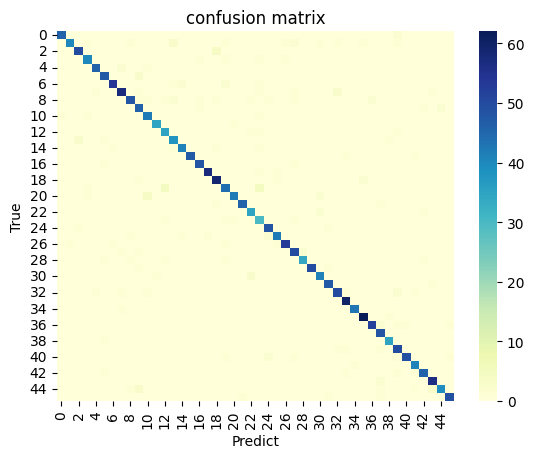

In [10]:
###############测试下#######################
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.random.seed(2023)
batch = 4
time_step = 1600
x_dim = 11
z_dim = 32
model_E = Encoder(time_step, x_dim,  z_dim)
model_D = Decoder(time_step, x_dim,  z_dim)
model_d = New_Impact_Discrimination()

x = tf.keras.layers.Input((time_step,x_dim))
z = model_E(x)
Re = model_D(z)
F,L=model_d(Re)
model_whole=tf.keras.Model(x,[F,L])
model_whole.summary()

model_E.load_weights('./PartA_newdata_method2(woMinMax)_model_E.h5')
model_D.load_weights('./PartA_newdata_method2(woMinMax)_model_D.h5')
model_d.load_weights('./PartA_newdata_method2(woMinMax)_model_Impact.h5')

y_predicted_L = []
y_Real_L = []
Force_p = []
Force_r = []
for count in range(int(len(Test_Time_Series)/4)):
    X =Test_Time_Series[4*count:4*(count+1)]
    F,L = model_whole(X)
    y_predicted_L.extend(np.argmax(L,axis=-1))
    y_Real_L.extend(np.argmax(Test_Location[4*count:4*(count+1)],axis=-1))
    Force_p.extend(F)
    Force_r.extend(Test_Force[4*count:4*(count+1)])
    
f,ax = plt.subplots()
y_true = np.squeeze(y_predicted_L)
y_pred = np.squeeze(y_Real_L)
C2 = confusion_matrix(y_true,y_pred,labels= [i for i in range(0,46)])
print(C2)
sns.heatmap(C2,annot=False,ax=ax,cmap="YlGnBu") #画热力图
ax.set_title('confusion matrix') #标题
ax.set_xlabel('Predict') #x 轴
ax.set_ylabel('True') #y 轴
print(sklearn.metrics.accuracy_score(y_true, y_pred))
print(sklearn.metrics.precision_score(y_true, y_pred,average='weighted'))
print(sklearn.metrics.recall_score(y_true, y_pred,average='weighted'))
print(sklearn.metrics.f1_score(y_true, y_pred,average='weighted'))

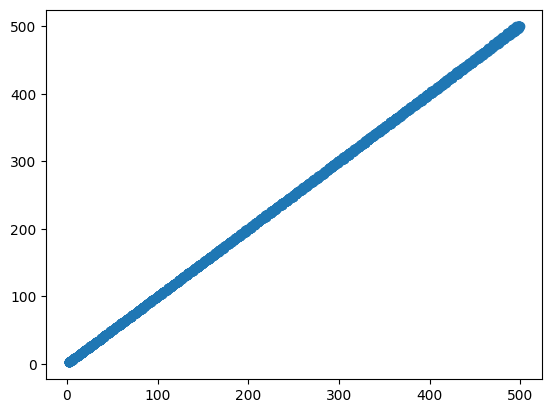

0.003363764210813892


In [11]:
plt.scatter(x=np.squeeze(Force_p),y=np.squeeze(Force_r))
plt.show()
print(sklearn.metrics.mean_absolute_percentage_error(np.squeeze(Force_r), np.squeeze(Force_p)))
SAVEDATA = pd.DataFrame(np.concatenate((np.squeeze(Force_p),np.squeeze(Force_r)),axis=-1))
SAVEDATA.to_excel(r"D:\AI in NTU\Proffu\Results\M2_CNN_N.xlsx")

In [11]:
class Encoder_delt(keras.Model):
    def __init__(self, time_step, x_dim, z_dim, name='encoder_delt', **kwargs):
        super(Encoder_delt, self).__init__(name=name, **kwargs)
        
        self.encoder_input = tf.keras.Input(shape=(time_step,x_dim))
        self.Conv1  =tf.keras.layers.Conv1D(16, 5, activation="relu", strides=1, padding="same")
        self.MaxPool1 = tf.keras.layers.MaxPool1D (pool_size=2, strides=2)
        self.Conv2 = tf.keras.layers.Conv1D(32, 5, activation="relu", strides=1, padding="same")
        self.MaxPool2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
        self.Conv3 = tf.keras.layers.Conv1D(64, 5, activation="relu", strides=1, padding="same")
        self.MaxPool3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
        self.Flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(z_dim, activation='linear')
        self.z = layers.Dense(z_dim, name='z')
    
    def call(self, inputs):
        self.encoder_inputs = inputs
        x =  self.Conv1(self.encoder_inputs)
        x = self.MaxPool1(x)
        x = self.Conv2(x)
        x = self.MaxPool2(x)
        x = self.Conv3(x)
        x = self.MaxPool3(x)
        x = self.Flatten(x)
        x = self.dense(x)
        z = self.z(x)
        return z

In [28]:
###############PART b########################
batch = 4
time_step =1600
x_dim = 11
z_dim = 32
model_E = Encoder(time_step, x_dim,  z_dim)
model_E_delt = Encoder_delt(time_step, x_dim, z_dim)
model_D = Decoder(time_step, x_dim,  z_dim)
model_d = New_Impact_Discrimination()

x = tf.keras.layers.Input((time_step,x_dim))
z = model_E(x,training=False)
z_d = model_E_delt(x,training=True)
z_new = tf.keras.layers.add([z,z_d])
Re = model_D(z_new,training=False)
F,L=model_d(Re,training=False)
model_whole=tf.keras.Model(x,[F,L])
model_whole.summary()

model_E.load_weights('./PartA_newdata_method2(woMinMax)_model_E.h5')
model_D.load_weights('./PartA_newdata_method2(woMinMax)_model_D.h5')
model_d.load_weights('./PartA_newdata_method2(woMinMax)_model_Impact.h5')

#model_whole.load_weights('./PartB_newdata_method2(woMinMax)_AEdouble.h5')
out_put_model_file = "./PartB_newdata_method2(woMinMax)_AEdouble.h5"
Callbacks=[
    tf.keras.callbacks.ModelCheckpoint(out_put_model_file,save_best_only=True,save_weights_only =True),
    #tf.keras.callbacks.EarlyStopping(patience=10,min_delta=1e-3),
]

model_whole.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss=[tf.keras.losses.MAE,tf.keras.losses.categorical_crossentropy])
history = model_whole.fit(x = Train_Real_ALL_Time, y=[Train_Real_ALL_Force,Train_Real_ALL_Location],epochs=100,batch_size=batch,validation_split=0.2, callbacks = Callbacks)
model_whole.load_weights('./PartB_newdata_method2(woMinMax)_AEdouble.h5')

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 1600, 11)]   0           []                               
                                                                                                  
 encoder (Encoder)              (None, 32)           424480      ['input_36[0][0]']               
                                                                                                  
 encoder_delt (Encoder_delt)    (None, 32)           424480      ['input_36[0][0]']               
                                                                                                  
 add_3801 (Add)                 (None, 32)           0           ['encoder[0][0]',                
                                                                  'encoder_delt[0][0]']    

Epoch 22/100
62/62 [==============================] - 5s 86ms/step - loss: 45.5673 - new__impact__discrimination_12_loss: 43.8539 - new__impact__discrimination_12_1_loss: 1.7135 - val_loss: 42.1529 - val_new__impact__discrimination_12_loss: 40.1327 - val_new__impact__discrimination_12_1_loss: 2.0202
Epoch 23/100
62/62 [==============================] - 5s 86ms/step - loss: 44.4368 - new__impact__discrimination_12_loss: 42.7999 - new__impact__discrimination_12_1_loss: 1.6369 - val_loss: 42.8171 - val_new__impact__discrimination_12_loss: 40.9423 - val_new__impact__discrimination_12_1_loss: 1.8748
Epoch 24/100
62/62 [==============================] - 5s 85ms/step - loss: 44.3434 - new__impact__discrimination_12_loss: 42.7724 - new__impact__discrimination_12_1_loss: 1.5710 - val_loss: 44.4915 - val_new__impact__discrimination_12_loss: 42.4577 - val_new__impact__discrimination_12_1_loss: 2.0338
Epoch 25/100
62/62 [==============================] - 5s 85ms/step - loss: 44.0001 - new__impact_

62/62 [==============================] - 5s 86ms/step - loss: 24.4693 - new__impact__discrimination_12_loss: 24.2225 - new__impact__discrimination_12_1_loss: 0.2467 - val_loss: 35.8976 - val_new__impact__discrimination_12_loss: 35.6106 - val_new__impact__discrimination_12_1_loss: 0.2869
Epoch 77/100
62/62 [==============================] - 5s 86ms/step - loss: 23.2372 - new__impact__discrimination_12_loss: 22.9886 - new__impact__discrimination_12_1_loss: 0.2486 - val_loss: 40.4368 - val_new__impact__discrimination_12_loss: 40.1497 - val_new__impact__discrimination_12_1_loss: 0.2871
Epoch 78/100
62/62 [==============================] - 5s 86ms/step - loss: 23.4710 - new__impact__discrimination_12_loss: 23.2383 - new__impact__discrimination_12_1_loss: 0.2327 - val_loss: 36.2502 - val_new__impact__discrimination_12_loss: 35.9436 - val_new__impact__discrimination_12_1_loss: 0.3067
Epoch 79/100
62/62 [==============================] - 5s 86ms/step - loss: 23.8712 - new__impact__discriminati

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1600, 11)]   0           []                               
                                                                                                  
 encoder (Encoder)              (None, 32)           424480      ['input_5[0][0]']                
                                                                                                  
 encoder_delt (Encoder_delt)    (None, 32)           424480      ['input_5[0][0]']                
                                                                                                  
 add_3450 (Add)                 (None, 32)           0           ['encoder[0][0]',                
                                                                  'encoder_delt[0][0]']     

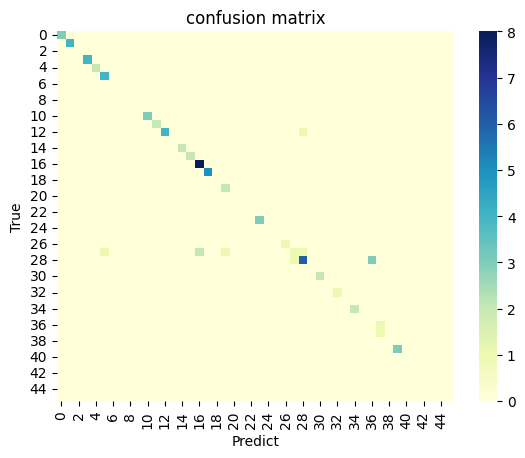

In [13]:
###############测试下#######################
import seaborn as sns
from sklearn.metrics import confusion_matrix
batch = 4
time_step = 1600
x_dim = 11
z_dim = 32
model_E = Encoder(time_step, x_dim,  z_dim)
model_E_delt = Encoder_delt(time_step, x_dim, z_dim)
model_D = Decoder(time_step, x_dim,  z_dim)
model_d = New_Impact_Discrimination()

x = tf.keras.layers.Input((time_step,x_dim))
z = model_E(x,training=False)
z_d = model_E_delt(x,training=False)
z_new = tf.keras.layers.add([z,z_d])
Re = model_D(z_new,training=False)
F,L=model_d(Re,training=False)
model_whole=tf.keras.Model(x,[F,L])
model_whole.summary()

model_whole.load_weights('./PartB_newdata_method2(woMinMax)_AEdouble.h5')

y_predicted_L = []
y_Real_L = []
Force_p = []
Force_r = []
for count in range(int(len(Test_Real_ALL_Time )/4)):
    X = Test_Real_ALL_Time [4*count:4*(count+1)]
    F,L = model_whole(X)
    y_predicted_L.extend(np.argmax(L,axis=-1))
    y_Real_L.extend(np.argmax(Test_Real_ALL_Location[4*count:4*(count+1)],axis=-1))
    Force_p.extend(F+0.3)
    Force_r.extend(Test_Real_ALL_Force[4*count:4*(count+1)])
    
f,ax = plt.subplots()
y_true = np.squeeze(y_predicted_L)
y_pred = np.squeeze(y_Real_L)
C2 = confusion_matrix(y_true,y_pred,labels= [i for i in range(0,46)])
print(C2)
sns.heatmap(C2,annot=False,ax=ax,cmap="YlGnBu") #画热力图
ax.set_title('confusion matrix') #标题
ax.set_xlabel('Predict') #x 轴
ax.set_ylabel('True') #y 轴
print(sklearn.metrics.accuracy_score(y_true, y_pred))
print(sklearn.metrics.precision_score(y_true, y_pred,average='weighted'))
print(sklearn.metrics.recall_score(y_true, y_pred,average='weighted'))
print(sklearn.metrics.f1_score(y_true, y_pred,average='weighted'))

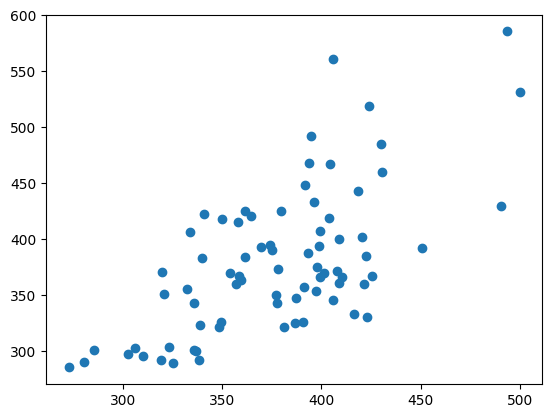

0.10165551609406769


In [14]:
plt.scatter(x=np.squeeze(Force_p),y=np.squeeze(Force_r))
plt.show()
print(sklearn.metrics.mean_absolute_percentage_error(np.squeeze(Force_r), np.squeeze(Force_p)))
SAVEDATA = pd.DataFrame(np.concatenate((np.squeeze(Force_p),np.squeeze(Force_r)),axis=-1))
SAVEDATA.to_excel(r"D:\AI in NTU\Proffu\Results\M2_CNN_R.xlsx")